# Segment Analysis — Paper Results Recreation

Recreates the core segment analysis results from the OneBQF paper using the `lhcb_velo_toy` package.

**Sections:**
1. Baseline event generation & classical reconstruction
2. Segment angle analysis and epsilon formula
3. Track density study (efficiency & ghost rate heatmaps)
4. Reconstruction efficiency vs ghost rate
5. Segment-level efficiency and false acceptance rate

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from itertools import product
import os

from lhcb_velo_toy import (
    PlaneGeometry,
    StateEventGenerator,
    SimpleHamiltonian,
    EventValidator,
    get_tracks,
    get_segments_from_event,
    get_all_possible_segments,
)
from lhcb_velo_toy.generation.entities import Track

sns.set(style='whitegrid')
plt.rcParams['figure.dpi'] = 100
plt.rcParams['figure.figsize'] = (10, 6)

os.makedirs('Plots', exist_ok=True)
print('Imports OK')

Imports OK


## Helper Functions

In [9]:
def generate_event(n_particles, layers=5, dz=33, lx=33, ly=33,
                   measurement_error=0.0, collision_noise=0.0,
                   pv_z_variance=0.0):
    """Generate a single event with the given parameters."""
    module_id = list(range(1, layers + 1))
    lx_list = [lx] * layers
    ly_list = [ly] * layers
    zs = [dz * l for l in range(1, layers + 1)]

    detector = PlaneGeometry(module_id=module_id, lx=lx_list, ly=ly_list, z=zs)

    gen = StateEventGenerator(
        detector, events=1, n_particles=[n_particles],
        measurement_error=measurement_error,
        collision_noise=collision_noise,
    )
    gen.generate_random_primary_vertices({'x': 0, 'y': 0, 'z': pv_z_variance})

    particles = [[{'type': 'MIP', 'mass': 0.511, 'q': 1}
                   for _ in range(n_particles)]]
    gen.generate_particles(particles)
    event = gen.generate_complete_events()
    return event, detector


def run_classical_reconstruction(event, epsilon=1e-7, alpha=2.0, beta=1.0,
                                  convolution=False, threshold=0.45):
    """Run classical Hamiltonian reconstruction and return tracks + metrics."""
    ham = SimpleHamiltonian(epsilon=epsilon, gamma=alpha, delta=beta)
    ham.construct_hamiltonian(event, convolution=convolution)
    solution = ham.solve_classicaly()
    
    # Discretize
    disc = (solution > threshold).astype(int)
    reco_tracks = get_tracks(ham, disc, event)
    
    # Validate
    validator = EventValidator(event, reco_tracks)
    matches, metrics = validator.match_tracks(purity_min=0.7)
    
    return {
        'ham': ham,
        'solution': solution,
        'disc': disc,
        'reco_tracks': reco_tracks,
        'matches': matches,
        'metrics': metrics,
    }


def compute_segment_angles(event):
    """Compute angles between consecutive segment pairs.
    
    Uses hit-level track_id to determine true vs false segment pairs,
    since get_all_possible_segments sets segment track_id=-1 for all.
    """
    # Get all possible segments (including cross-track)
    all_segs = get_all_possible_segments(event)
    
    true_angles = []
    false_angles = []
    
    # Group by shared middle hit
    segs_by_hit_start = {}
    for seg in all_segs:
        hid = seg.hit_start.hit_id
        if hid not in segs_by_hit_start:
            segs_by_hit_start[hid] = []
        segs_by_hit_start[hid].append(seg)
    
    # Find pairs sharing a middle hit (seg.hit_end == seg2.hit_start)
    for seg in all_segs:
        end_id = seg.hit_end.hit_id
        if end_id in segs_by_hit_start:
            for seg2 in segs_by_hit_start[end_id]:
                cosine = seg * seg2
                angle = np.arccos(np.clip(cosine, -1, 1))
                
                # Use HIT-level track_id (not segment track_id, which is
                # always -1 for get_all_possible_segments)
                tid_start = seg.hit_start.track_id
                tid_mid   = seg.hit_end.track_id    # == seg2.hit_start
                tid_end   = seg2.hit_end.track_id
                
                is_true = (tid_start is not None and tid_start >= 0 and
                          tid_start == tid_mid == tid_end)
                if is_true:
                    true_angles.append(angle)
                else:
                    false_angles.append(angle)
    
    return np.array(true_angles), np.array(false_angles)


---
## 1. Baseline Event Generation & Reconstruction

In [10]:
# Generate a baseline event: 10 tracks, 5 layers, no noise
event, detector = generate_event(n_particles=10, layers=5)

print(f"Tracks: {event.n_tracks}")
print(f"Hits: {event.n_hits}")
print(f"Modules: {event.n_modules}")

# Classical reconstruction
result = run_classical_reconstruction(event)
print(f"\nReco tracks: {len(result['reco_tracks'])}")
print(f"Efficiency: {result['metrics']['efficiency']:.1%}")
print(f"Ghost Rate: {result['metrics']['ghost_rate']:.1%}")
print(f"Clone Fraction: {result['metrics']['clone_fraction']:.1%}")
print(f"Mean Purity: {result['metrics']['mean_purity']:.3f}")

Tracks: 10
Hits: 50
Modules: 5

Reco tracks: 10
Efficiency: 100.0%
Ghost Rate: 0.0%
Clone Fraction: 0.0%
Mean Purity: 1.000


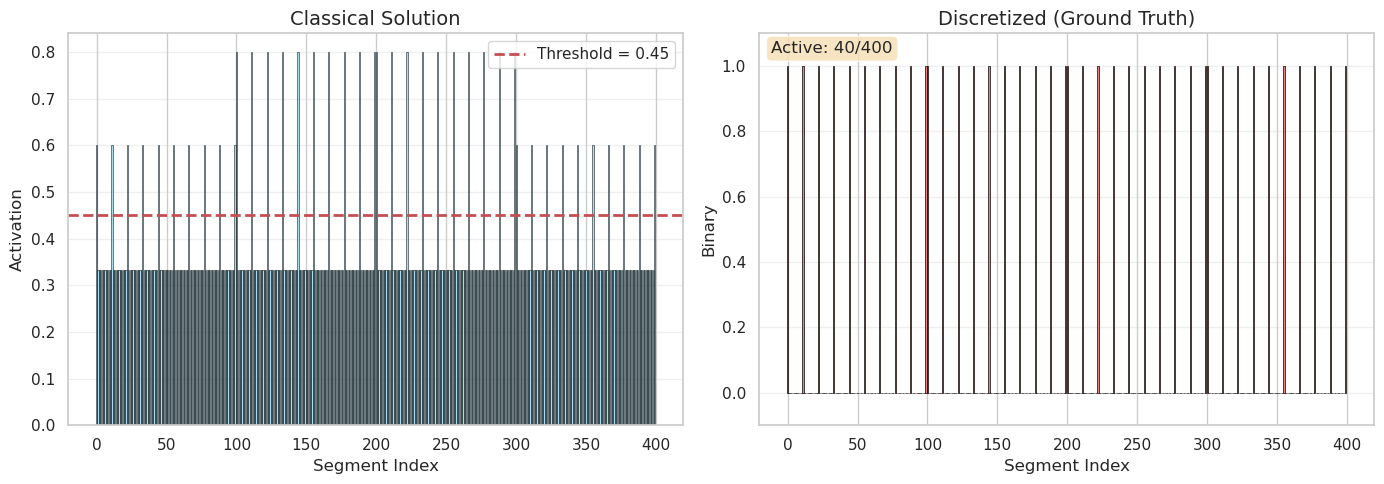

In [11]:
# Solution comparison plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

indices = np.arange(len(result['solution']))
ax1.bar(indices, result['solution'], color='skyblue', alpha=0.7, edgecolor='black', lw=0.5)
ax1.axhline(y=0.45, color='r', ls='--', lw=2, label='Threshold = 0.45')
ax1.set_title('Classical Solution', fontsize=14)
ax1.set_xlabel('Segment Index'); ax1.set_ylabel('Activation')
ax1.legend(); ax1.grid(alpha=0.3, axis='y')

colors = ['lightcoral' if x == 1 else 'lightgray' for x in result['disc']]
ax2.bar(indices, result['disc'], color=colors, edgecolor='black', lw=0.5)
ax2.set_title('Discretized (Ground Truth)', fontsize=14)
ax2.set_xlabel('Segment Index'); ax2.set_ylabel('Binary')
ax2.set_ylim(-0.1, 1.1)
n_active = np.sum(result['disc'])
ax2.text(0.02, 0.98, f'Active: {n_active}/{len(result["disc"])}',
         transform=ax2.transAxes, va='top',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
ax2.grid(alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('Plots/baseline_solution_comparison.jpeg', dpi=300, bbox_inches='tight')
plt.show()

---
## 2. Segment Angle Analysis

Epsilon formula from the paper:

$$\varepsilon = \sqrt{2\theta_s^2 + 12\theta_r^2 + 2\theta_{\min}^2}$$

where $\theta_s$ is scattering angle, $\theta_r$ is resolution angle, and $\theta_{\min}$ is the minimum opening angle.

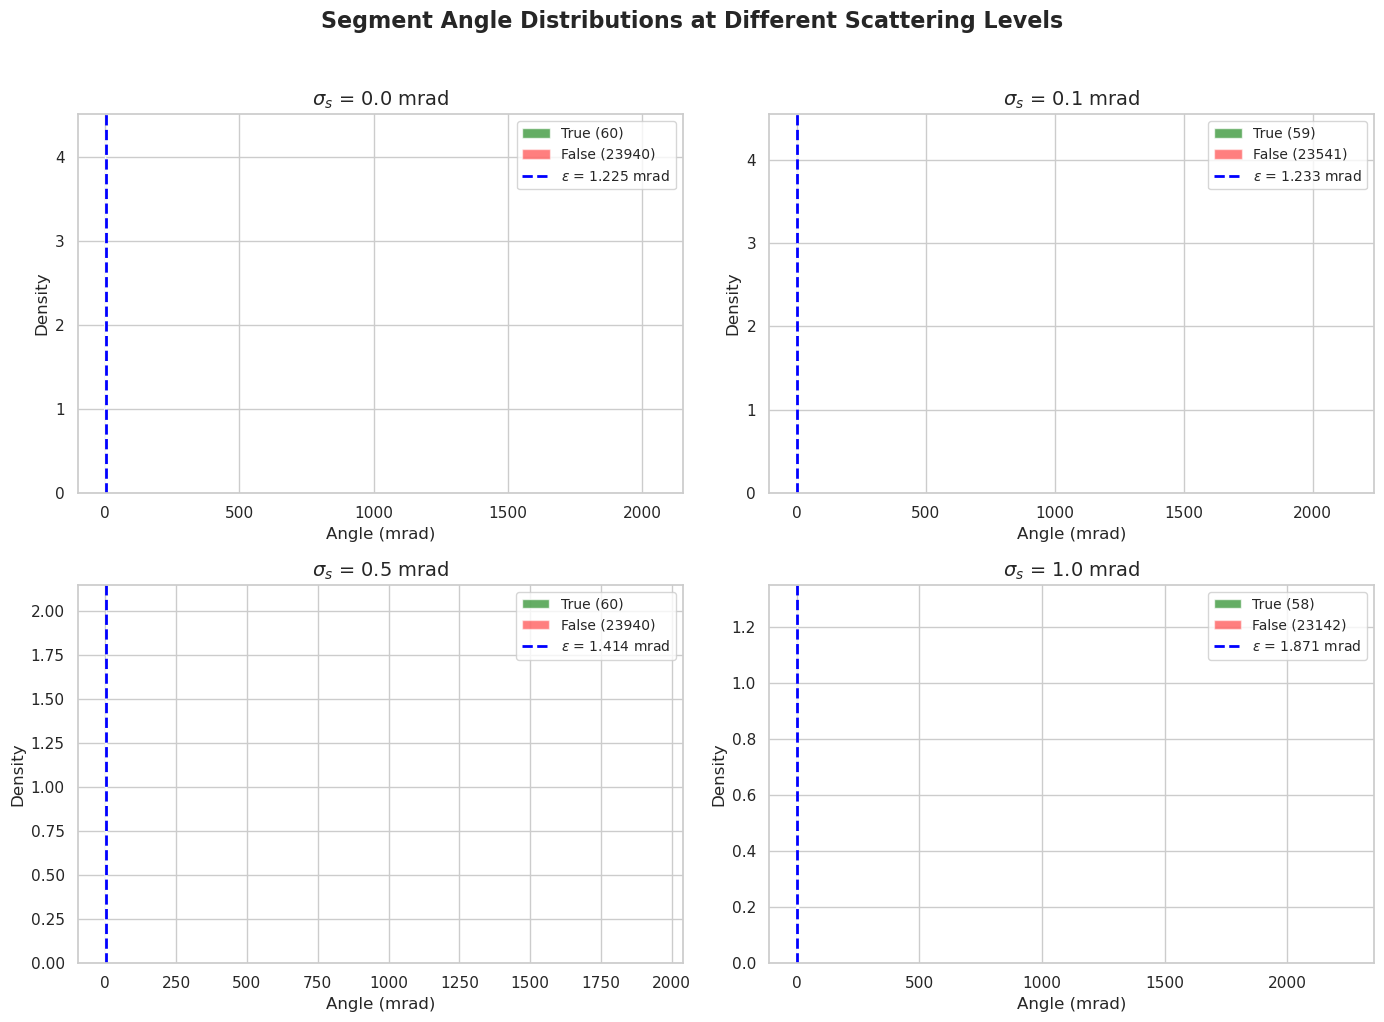

In [12]:
# Generate events at different scattering levels
scattering_values = [0.0, 0.1e-3, 0.5e-3, 1.0e-3]
resolution = 5e-3  # 5 microns

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

for ax, sigma_s in zip(axes.ravel(), scattering_values):
    ev, det = generate_event(n_particles=20, layers=5,
                             measurement_error=resolution,
                             collision_noise=sigma_s)
    true_angles, false_angles = compute_segment_angles(ev)
    
    if len(true_angles) > 0:
        ax.hist(true_angles * 1e3, bins=50, alpha=0.7, color='forestgreen',
                label=f'True ({len(true_angles)})', density=True)
    if len(false_angles) > 0:
        ax.hist(false_angles * 1e3, bins=50, alpha=0.5, color='red',
                label=f'False ({len(false_angles)})', density=True)
    
    # Epsilon formula
    dz = 20
    theta_r = np.sqrt(2) * resolution / dz
    theta_s = sigma_s
    theta_min = 0
    eps = np.sqrt(2 * theta_s**2 + 12 * theta_r**2 + 2 * theta_min**2)
    ax.axvline(eps * 1e3, color='blue', ls='--', lw=2,
               label=f'$\\varepsilon$ = {eps*1e3:.3f} mrad')
    
    ax.set_title(f'$\\sigma_s$ = {sigma_s*1e3:.1f} mrad', fontsize=14)
    ax.set_xlabel('Angle (mrad)'); ax.set_ylabel('Density')
    ax.legend(fontsize=10)

plt.suptitle('Segment Angle Distributions at Different Scattering Levels',
             fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('Plots/segment_angle_analysis.jpeg', dpi=300, bbox_inches='tight')
plt.show()

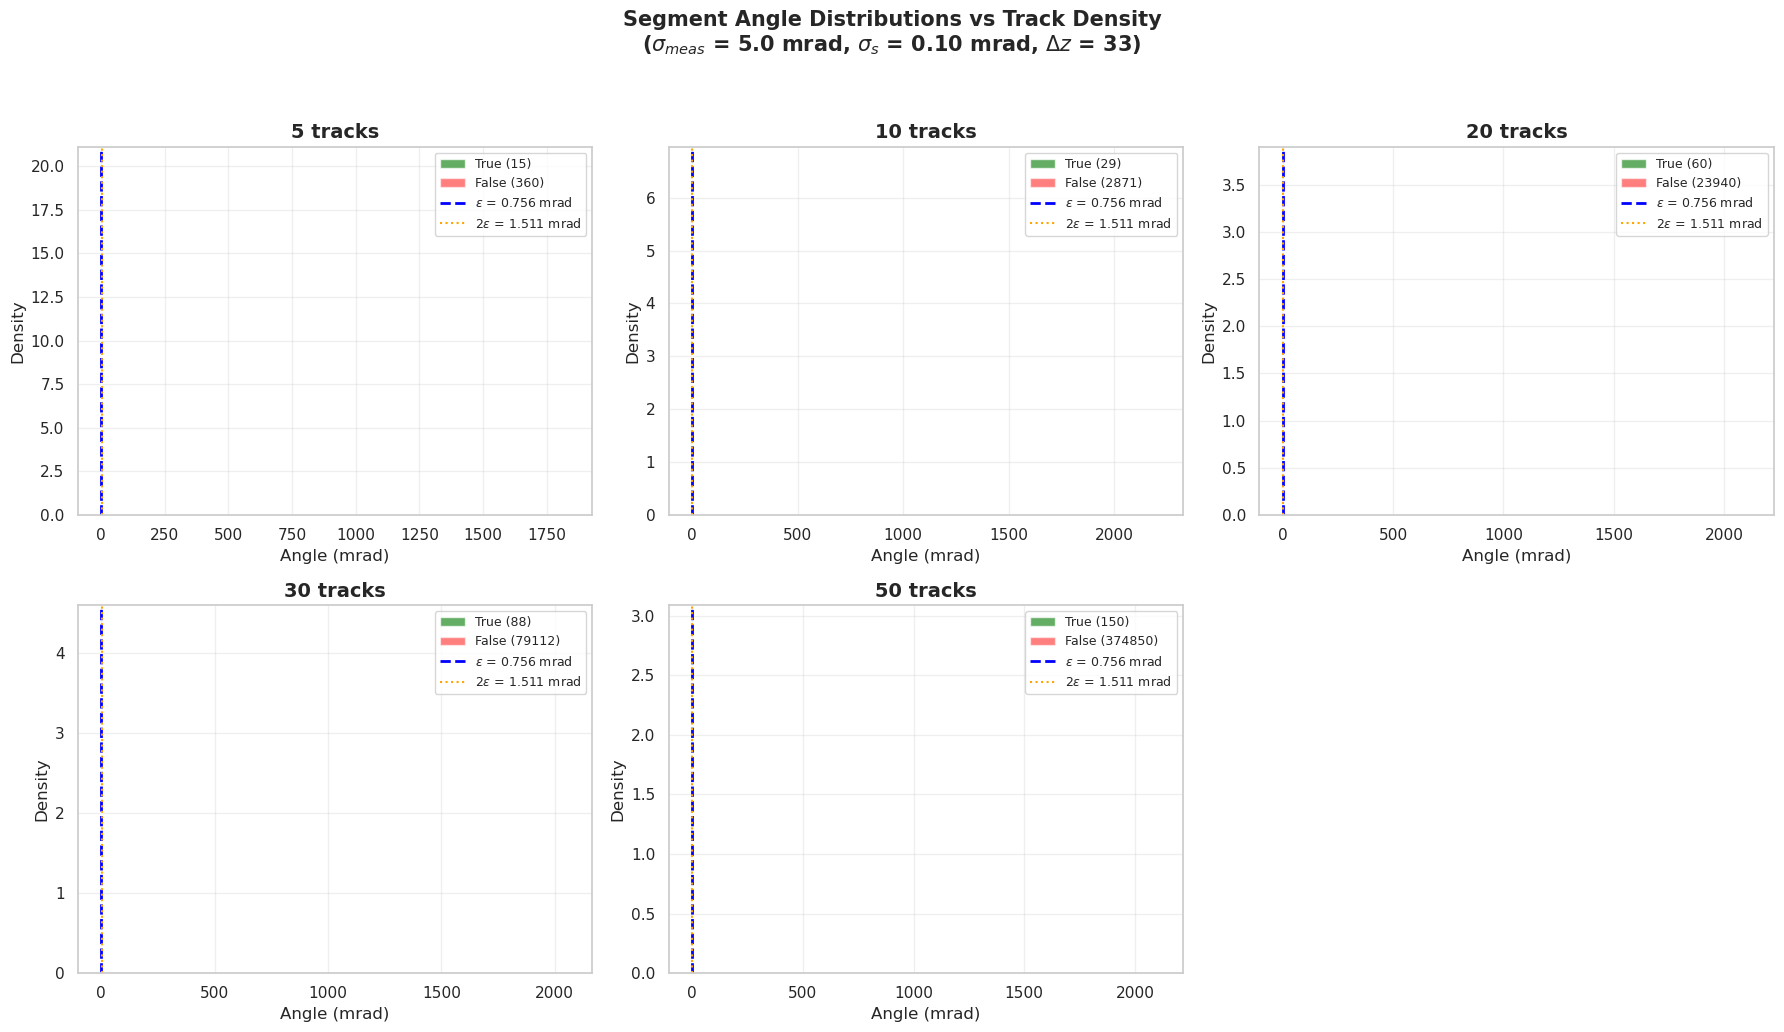

In [13]:
# Segment angle distributions & epsilon for 5–50 tracks
track_counts_sweep = [5, 10, 20, 30, 50]
dz = 33  # layer spacing used in generate_event
measurement_error = 5e-3
collision_noise = 0.1e-3

n_cols = 3
n_rows = int(np.ceil(len(track_counts_sweep) / n_cols))
fig, axes = plt.subplots(n_rows, n_cols, figsize=(6 * n_cols, 5 * n_rows))
axes = axes.ravel()

for idx, n_trk in enumerate(track_counts_sweep):
    ax = axes[idx]
    ev, det = generate_event(n_particles=n_trk, layers=5, dz=dz,
                             measurement_error=measurement_error,
                             collision_noise=collision_noise)
    true_angles, false_angles = compute_segment_angles(ev)

    if len(true_angles) > 0:
        ax.hist(true_angles * 1e3, bins=60, alpha=0.7, color='forestgreen',
                label=f'True ({len(true_angles)})', density=True)
    if len(false_angles) > 0:
        ax.hist(false_angles * 1e3, bins=60, alpha=0.5, color='red',
                label=f'False ({len(false_angles)})', density=True)

    # Compute epsilon from the paper formula
    theta_r = np.sqrt(2) * measurement_error / dz
    theta_s = collision_noise
    eps = np.sqrt(2 * theta_s**2 + 12 * theta_r**2)
    ax.axvline(eps * 1e3, color='blue', ls='--', lw=2,
               label=f'$\\varepsilon$ = {eps*1e3:.3f} mrad')

    # Also show 2*epsilon and 3*epsilon for reference
    ax.axvline(2 * eps * 1e3, color='orange', ls=':', lw=1.5,
               label=f'$2\\varepsilon$ = {2*eps*1e3:.3f} mrad')

    ax.set_title(f'{n_trk} tracks', fontsize=14, fontweight='bold')
    ax.set_xlabel('Angle (mrad)')
    ax.set_ylabel('Density')
    ax.legend(fontsize=9)
    ax.grid(alpha=0.3)

# Hide unused axes
for ax in axes[len(track_counts_sweep):]:
    ax.set_visible(False)

plt.suptitle(
    f'Segment Angle Distributions vs Track Density\n'
    f'($\\sigma_{{meas}}$ = {measurement_error*1e3:.1f} mrad, '
    f'$\\sigma_s$ = {collision_noise*1e3:.2f} mrad, '
    f'$\\Delta z$ = {dz})',
    fontsize=15, fontweight='bold', y=1.03)
plt.tight_layout()
plt.savefig('Plots/segment_angles_vs_density.jpeg', dpi=300, bbox_inches='tight')
plt.show()


---
## 3. Track Density Study

Sweep over number of tracks and evaluate reconstruction performance.

In [ ]:
# Track density scan
track_counts = [5, 10, 20, 30, 50, 75, 100]
n_repeats = 5

density_results = []

for n_tracks in track_counts:
    for rep in range(n_repeats):
        ev, det = generate_event(n_particles=n_tracks, layers=5,
                                 measurement_error=10e-3,
                                 collision_noise=0)#.1e-3)
        try:
            res = run_classical_reconstruction(ev, epsilon=1e-7, alpha=2.0, beta=1.0)
            density_results.append({
                'n_tracks': n_tracks,
                'repeat': rep,
                'efficiency': res['metrics']['efficiency'],
                'ghost_rate': res['metrics']['ghost_rate'],
                'clone_fraction': res['metrics']['clone_fraction'],
                'mean_purity': res['metrics']['mean_purity'],
                'n_reco': len(res['reco_tracks']),
            })
        except Exception as e:
            print(f"  Error at n={n_tracks}, rep={rep}: {e}")
    print(f"  n_tracks={n_tracks} done")

df_density = pd.DataFrame(density_results)
print(f"\nTotal runs: {len(df_density)}")
print(df_density.groupby('n_tracks')[['efficiency', 'ghost_rate']].mean())

  n_tracks=5 done
  n_tracks=10 done
  n_tracks=20 done
  n_tracks=30 done
  n_tracks=50 done
  n_tracks=75 done


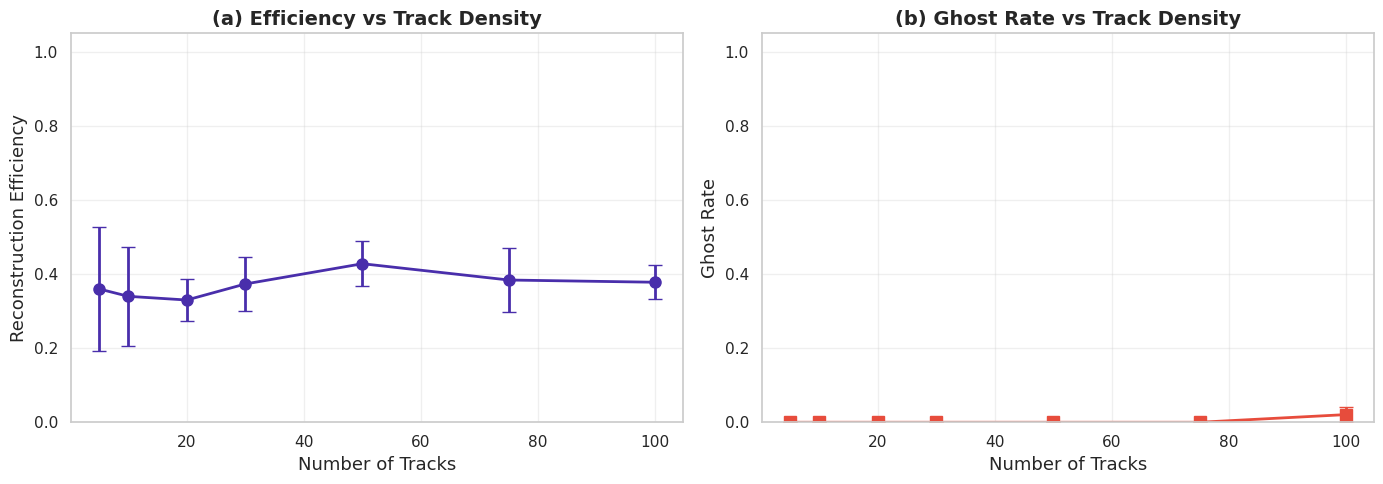

In [ ]:
# Efficiency and Ghost Rate vs Track Count
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

agg = df_density.groupby('n_tracks').agg(
    eff_mean=('efficiency', 'mean'),
    eff_std=('efficiency', 'std'),
    ghost_mean=('ghost_rate', 'mean'),
    ghost_std=('ghost_rate', 'std'),
).reset_index()

ax1.errorbar(agg['n_tracks'], agg['eff_mean'], yerr=agg['eff_std'],
             fmt='o-', capsize=5, color='#492EAB', lw=2, ms=8)
ax1.set_xlabel('Number of Tracks', fontsize=13)
ax1.set_ylabel('Reconstruction Efficiency', fontsize=13)
ax1.set_title('(a) Efficiency vs Track Density', fontsize=14, fontweight='bold')
ax1.set_ylim(0, 1.05)
ax1.grid(alpha=0.3)

ax2.errorbar(agg['n_tracks'], agg['ghost_mean'], yerr=agg['ghost_std'],
             fmt='s-', capsize=5, color='#E74C3C', lw=2, ms=8)
ax2.set_xlabel('Number of Tracks', fontsize=13)
ax2.set_ylabel('Ghost Rate', fontsize=13)
ax2.set_title('(b) Ghost Rate vs Track Density', fontsize=14, fontweight='bold')
ax2.set_ylim(0, 1.05)
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('Plots/density_study_eff_ghost.jpeg', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
# Track density scan
track_counts = [5, 10, 20, 30, 50, 75, 100]
n_repeats = 1
mes_erros = [i*1e-2 for i in range(0,10)]
density_results = []

for n_tracks in track_counts:
    for rep in range(n_repeats):
        for mes_error in mes_erros:
            ev, det = generate_event(n_particles=n_tracks, layers=5,
                                     measurement_error=mes_error,
                                     collision_noise=0)#.1e-3)
            try:
                res = run_classical_reconstruction(ev, epsilon=1e-7, alpha=2.0, beta=1.0)
                density_results.append({
                    'n_tracks': n_tracks,
                    'repeat': rep,
                    'measurement_error': mes_error,
                    'efficiency': res['metrics']['efficiency'],
                    'ghost_rate': res['metrics']['ghost_rate'],
                    'clone_fraction': res['metrics']['clone_fraction'],
                    'mean_purity': res['metrics']['mean_purity'],
                    'n_reco': len(res['reco_tracks']),
                })
            except Exception as e:
                print(f"  Error at n={n_tracks}, rep={rep}, mes_error={mes_error}: {e}")
    print(f"  n_tracks={n_tracks} done")

df_density = pd.DataFrame(density_results)
print(f"\nTotal runs: {len(df_density)}")
print(df_density.groupby('n_tracks')[['efficiency', 'ghost_rate']].mean())

  n_tracks=5 done
  n_tracks=10 done
  n_tracks=20 done
  n_tracks=30 done
  n_tracks=50 done
  n_tracks=75 done
  n_tracks=100 done

Total runs: 70
          efficiency  ghost_rate
n_tracks                        
5           0.180000    0.000000
10          0.160000    0.000000
20          0.175000    0.000000
30          0.160000    0.009091
50          0.174000    0.025000
75          0.146667    0.126408
100         0.180000    0.044574


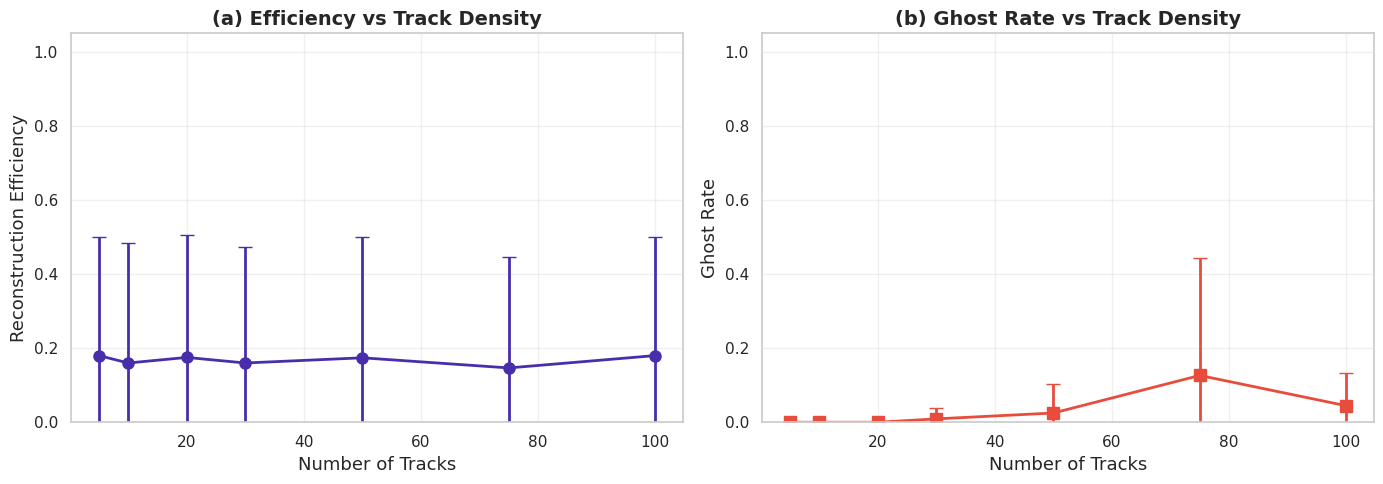

In [ ]:
# Efficiency and Ghost Rate vs Track Count
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

agg = df_density.groupby('n_tracks').agg(
    eff_mean=('efficiency', 'mean'),
    eff_std=('efficiency', 'std'),
    ghost_mean=('ghost_rate', 'mean'),
    ghost_std=('ghost_rate', 'std'),
).reset_index()

ax1.errorbar(agg['n_tracks'], agg['eff_mean'], yerr=agg['eff_std'],
             fmt='o-', capsize=5, color='#492EAB', lw=2, ms=8)
ax1.set_xlabel('Number of Tracks', fontsize=13)
ax1.set_ylabel('Reconstruction Efficiency', fontsize=13)
ax1.set_title('(a) Efficiency vs Track Density', fontsize=14, fontweight='bold')
ax1.set_ylim(0, 1.05)
ax1.grid(alpha=0.3)

ax2.errorbar(agg['n_tracks'], agg['ghost_mean'], yerr=agg['ghost_std'],
             fmt='s-', capsize=5, color='#E74C3C', lw=2, ms=8)
ax2.set_xlabel('Number of Tracks', fontsize=13)
ax2.set_ylabel('Ghost Rate', fontsize=13)
ax2.set_title('(b) Ghost Rate vs Track Density', fontsize=14, fontweight='bold')
ax2.set_ylim(0, 1.05)
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('Plots/density_study_eff_ghost.jpeg', dpi=300, bbox_inches='tight')
plt.show()

---
## 4. Efficiency vs Ghost Rate Scatter

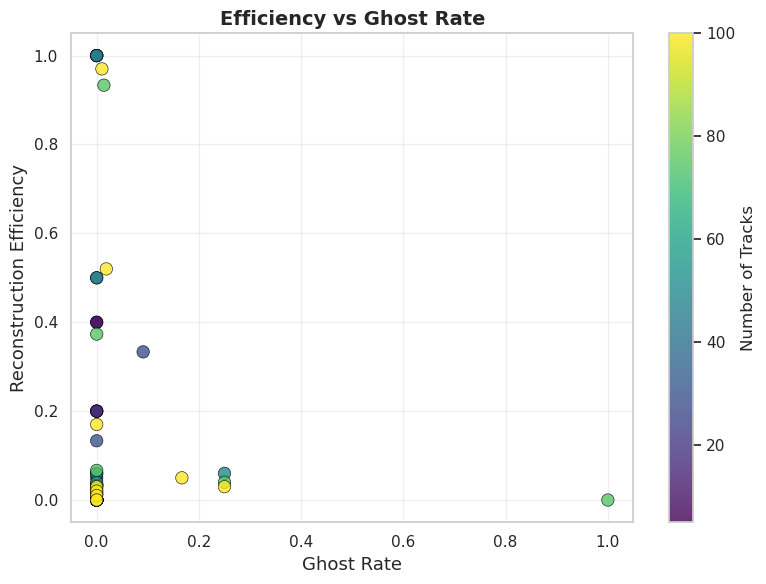

In [ ]:
fig, ax = plt.subplots(figsize=(8, 6))

scatter = ax.scatter(df_density['ghost_rate'], df_density['efficiency'],
                     c=df_density['n_tracks'], cmap='viridis', s=80,
                     edgecolors='black', lw=0.5, alpha=0.8)
cbar = plt.colorbar(scatter, ax=ax, label='Number of Tracks')

ax.set_xlabel('Ghost Rate', fontsize=13)
ax.set_ylabel('Reconstruction Efficiency', fontsize=13)
ax.set_title('Efficiency vs Ghost Rate', fontsize=14, fontweight='bold')
ax.set_xlim(-0.05, 1.05)
ax.set_ylim(-0.05, 1.05)
ax.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('Plots/eff_vs_ghost_scatter.jpeg', dpi=300, bbox_inches='tight')
plt.show()

---
## 5. Segment-Level Efficiency

Measures:
- Segment efficiency: $N_{\text{true accepted}} / N_{\text{true pairs}}$
- False acceptance rate: $N_{\text{false accepted}} / N_{\text{all accepted}}$

In [ ]:
# Segment-level analysis
seg_track_counts = [10, 20, 50, 100]
seg_n_repeats = 10
seg_results = []

for n_tracks in seg_track_counts:
    for rep in range(seg_n_repeats):
        ev, det = generate_event(n_particles=n_tracks, layers=5,
                                 measurement_error=5e-3,
                                 collision_noise=0.1e-3)
        
        ham = SimpleHamiltonian(epsilon=1e-7, gamma=2.0, delta=1.0)
        ham.construct_hamiltonian(ev, convolution=False)
        solution = ham.solve_classicaly()
        disc = (solution > 0.45).astype(int)
        
        # Count true and false accepted segments
        n_true_total = 0
        n_true_accepted = 0
        n_false_accepted = 0
        n_total_accepted = 0
        
        for seg, val in zip(ham.segments, disc):
            is_true = (seg.hit_start.track_id == seg.hit_end.track_id and
                      seg.hit_start.track_id >= 0)
            if is_true:
                n_true_total += 1
            if val == 1:
                n_total_accepted += 1
                if is_true:
                    n_true_accepted += 1
                else:
                    n_false_accepted += 1
        
        seg_eff = n_true_accepted / n_true_total if n_true_total > 0 else 0
        false_rate = n_false_accepted / n_total_accepted if n_total_accepted > 0 else 0
        
        seg_results.append({
            'n_tracks': n_tracks,
            'repeat': rep,
            'seg_efficiency': seg_eff,
            'false_rate': false_rate,
            'n_true_total': n_true_total,
            'n_true_accepted': n_true_accepted,
            'n_false_accepted': n_false_accepted,
            'n_total_accepted': n_total_accepted,
        })
    print(f"  n_tracks={n_tracks} done")

df_seg = pd.DataFrame(seg_results)
print(f"\nResults:")
print(df_seg.groupby('n_tracks')[['seg_efficiency', 'false_rate']].mean())

  n_tracks=10 done
  n_tracks=20 done
  n_tracks=50 done
  n_tracks=100 done

Results:
          seg_efficiency  false_rate
n_tracks                            
10              0.625385    0.000000
20              0.585823    0.000000
50              0.604009    0.000000
100             0.604636    0.005338


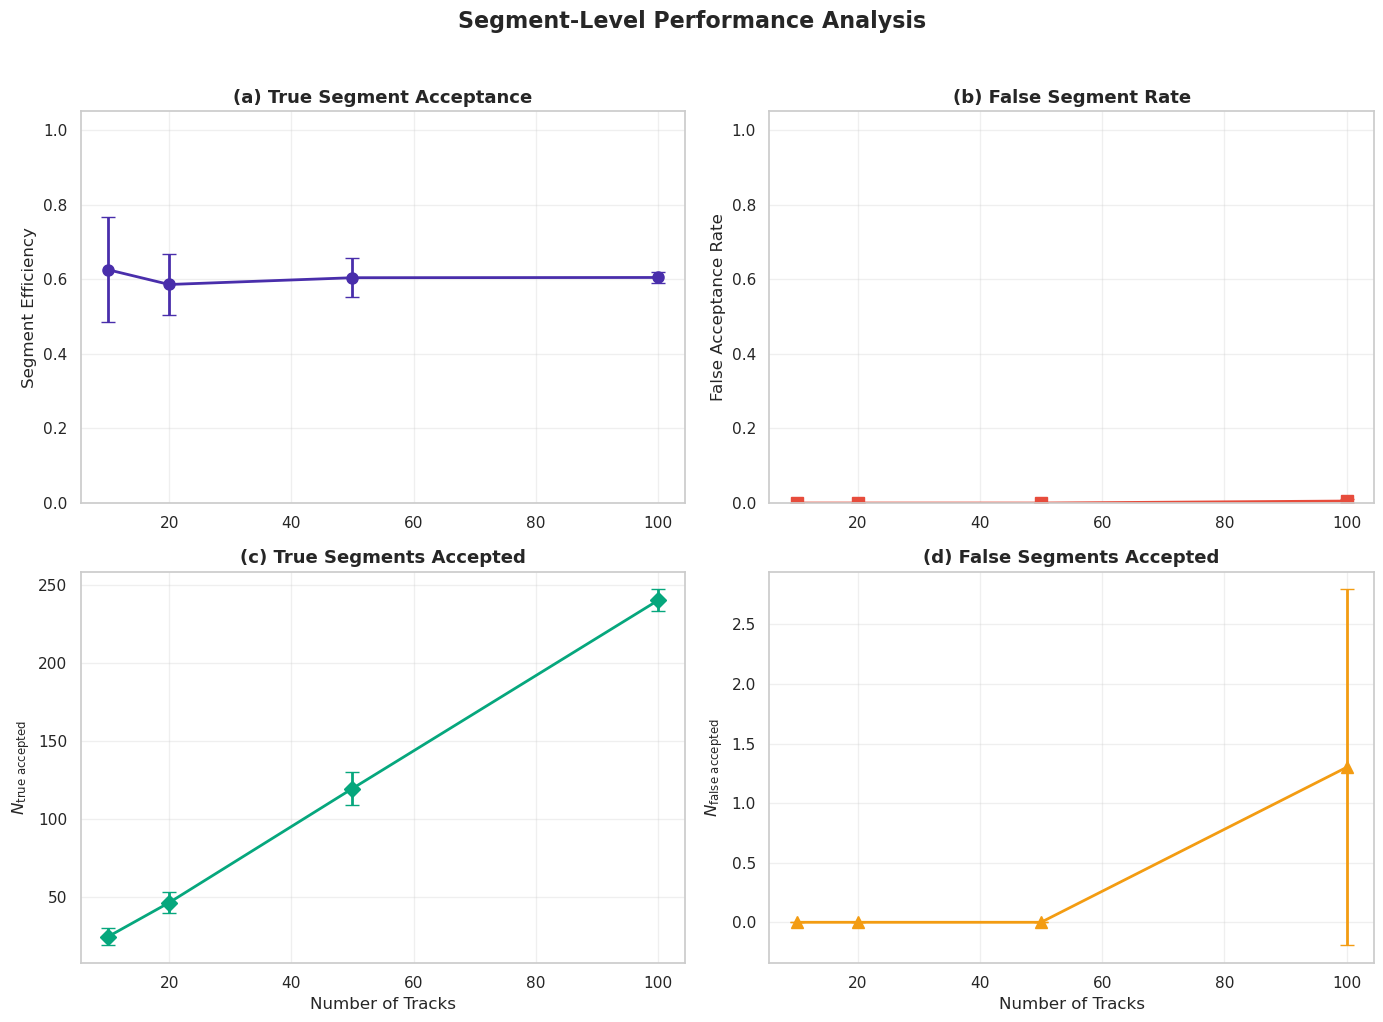

In [ ]:
# Paper-ready 4-panel segment analysis figure
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

agg_seg = df_seg.groupby('n_tracks').agg(
    seg_eff_mean=('seg_efficiency', 'mean'),
    seg_eff_std=('seg_efficiency', 'std'),
    false_mean=('false_rate', 'mean'),
    false_std=('false_rate', 'std'),
    true_acc_mean=('n_true_accepted', 'mean'),
    true_acc_std=('n_true_accepted', 'std'),
    false_acc_mean=('n_false_accepted', 'mean'),
    false_acc_std=('n_false_accepted', 'std'),
).reset_index()

# (a) Segment Efficiency
axes[0, 0].errorbar(agg_seg['n_tracks'], agg_seg['seg_eff_mean'],
                    yerr=agg_seg['seg_eff_std'], fmt='o-', capsize=5,
                    color='#492EAB', lw=2, ms=8)
axes[0, 0].set_ylabel('Segment Efficiency', fontsize=12)
axes[0, 0].set_title('(a) True Segment Acceptance', fontsize=13, fontweight='bold')
axes[0, 0].set_ylim(0, 1.05)
axes[0, 0].grid(alpha=0.3)

# (b) False Acceptance Rate
axes[0, 1].errorbar(agg_seg['n_tracks'], agg_seg['false_mean'],
                    yerr=agg_seg['false_std'], fmt='s-', capsize=5,
                    color='#E74C3C', lw=2, ms=8)
axes[0, 1].set_ylabel('False Acceptance Rate', fontsize=12)
axes[0, 1].set_title('(b) False Segment Rate', fontsize=13, fontweight='bold')
axes[0, 1].set_ylim(0, 1.05)
axes[0, 1].grid(alpha=0.3)

# (c) True Segments Accepted
axes[1, 0].errorbar(agg_seg['n_tracks'], agg_seg['true_acc_mean'],
                    yerr=agg_seg['true_acc_std'], fmt='D-', capsize=5,
                    color='#06A77D', lw=2, ms=8)
axes[1, 0].set_xlabel('Number of Tracks', fontsize=12)
axes[1, 0].set_ylabel('$N_{\\text{true accepted}}$', fontsize=12)
axes[1, 0].set_title('(c) True Segments Accepted', fontsize=13, fontweight='bold')
axes[1, 0].grid(alpha=0.3)

# (d) False Segments Accepted
axes[1, 1].errorbar(agg_seg['n_tracks'], agg_seg['false_acc_mean'],
                    yerr=agg_seg['false_acc_std'], fmt='^-', capsize=5,
                    color='#F39C12', lw=2, ms=8)
axes[1, 1].set_xlabel('Number of Tracks', fontsize=12)
axes[1, 1].set_ylabel('$N_{\\text{false accepted}}$', fontsize=12)
axes[1, 1].set_title('(d) False Segments Accepted', fontsize=13, fontweight='bold')
axes[1, 1].grid(alpha=0.3)

plt.suptitle('Segment-Level Performance Analysis',
             fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('Plots/segment_level_analysis.jpeg', dpi=300, bbox_inches='tight')
plt.savefig('Plots/segment_level_analysis.pdf', dpi=300, bbox_inches='tight')
plt.show()

---
## Summary Statistics

In [ ]:
print('=' * 70)
print('TRACK DENSITY STUDY SUMMARY')
print('=' * 70)
summary = df_density.groupby('n_tracks').agg(
    eff=('efficiency', lambda x: f"{x.mean():.3f}±{x.std():.3f}"),
    ghost=('ghost_rate', lambda x: f"{x.mean():.3f}±{x.std():.3f}"),
    purity=('mean_purity', lambda x: f"{x.mean():.3f}±{x.std():.3f}"),
)
print(summary.to_string())

print('\n' + '=' * 70)
print('SEGMENT-LEVEL ANALYSIS SUMMARY')
print('=' * 70)
seg_summary = df_seg.groupby('n_tracks').agg(
    seg_eff=('seg_efficiency', lambda x: f"{x.mean():.3f}±{x.std():.3f}"),
    false_r=('false_rate', lambda x: f"{x.mean():.3f}±{x.std():.3f}"),
)
print(seg_summary.to_string())

TRACK DENSITY STUDY SUMMARY
                  eff        ghost       purity
n_tracks                                       
5         0.180±0.319  0.000±0.000  0.400±0.516
10        0.160±0.324  0.000±0.000  0.300±0.483
20        0.175±0.331  0.000±0.000  0.400±0.516
30        0.160±0.312  0.009±0.029  0.700±0.483
50        0.174±0.327  0.025±0.079  0.700±0.483
75        0.147±0.299  0.126±0.317  0.700±0.483
100       0.180±0.320  0.045±0.089  0.800±0.422

SEGMENT-LEVEL ANALYSIS SUMMARY
              seg_eff      false_r
n_tracks                          
10        0.625±0.140  0.000±0.000
20        0.586±0.083  0.000±0.000
50        0.604±0.053  0.000±0.000
100       0.605±0.016  0.005±0.006
